# Project LDM generated latents back to MRMS space

In [1]:
import os
import sys
import time
import numpy as np
from glob import glob

import logging
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import vae_utils as vu
import model_utils as mu

In [3]:
def precip_norm(x):
    return np.log(x+1)

## Hyperparameters

In [4]:
filter_nums = [64, 128] # number of convolution kernels per down-/upsampling layer 
latent_dim = 8 # number of latent feature channels
activation = 'relu' # activation function
num_embeddings = 128 # number of the VQ codes

input_size = (32, 32, latent_dim) # size of LDM features

load_weights = False

# location of the previous weights
model_name_load = '/glade/work/ksha/GAN/models/PROJ_{}_{}_L{}_N{}_{}_base'.format(
    filter_nums[0], filter_nums[1], latent_dim, num_embeddings, activation)
# location for saving new weights
model_name_save = '/glade/work/ksha/GAN/models/PROJ_{}_{}_L{}_N{}_{}_base'.format(
    filter_nums[0], filter_nums[1], latent_dim, num_embeddings, activation)

lr = 1e-4 # learning rate
# samples per epoch = N_batch * batch_size
epochs = 99999
N_batch = 64

## Model design

In [5]:
# print('tf.version = {}'.format(tf.__version__))
# print('tf on GPU = {}'.format(tf.test.is_gpu_available()))

In [7]:
# ---------------- decoder ----------------- #

decoder_in = keras.Input(shape=input_size)

X = decoder_in

X = layers.Conv2D(filter_nums[1], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)

X = layers.Conv2D(filter_nums[1], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)

X = layers.Conv2D(filter_nums[1], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

decoder_out = layers.Conv2D(1, (3, 3), padding="same")(X)

model = keras.Model(decoder_in, decoder_out)

# load weights
if load_weights:
    W_old = mu.dummy_loader(model_name_load)
    model.set_weights(W_old)

# compile
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(learning_rate=lr))

## Validation set preparation

In [8]:
# location of training data
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/LDM_results_train/'
# validation set size
L_valid = 4 # *100

# collect validation set sampales
filenames = np.array(sorted(glob(BATCH_dir+'*.npy')))
L = len(filenames)
filename_valid = filenames[:][:L_valid]

# MRMS batches were not normalized
X_valid = np.empty((L_valid*100,)+input_size)
X_valid[...] = np.nan

Y_valid = np.empty((L_valid*100, 128, 128, 1))
Y_valid[...] = np.nan

for i, name in enumerate(filename_valid):
    temp_data = np.load(name, allow_pickle=True)[()]
    for j in range(10):
        X_valid[100*i+10*j:100*i+10*(j+1), ...] = temp_data['LDM_latent'][:, j, ...]
        Y_valid[100*i+10*j:100*i+10*(j+1), ..., 0] = temp_data['MRMS_true'][j, ...]

flag_good = np.sum(np.isnan(X_valid), axis=(1, 2, 3)) == 0
X_valid = X_valid[flag_good, ...]
Y_valid = Y_valid[flag_good, ...]

In [9]:
Y_pred = model.predict(X_valid)

13/13 [==============================] - 18s 1s/step


In [10]:
du.mean_absolute_error(Y_valid, Y_pred)

0.12232521575398231

## Model training

In [11]:
# collect training samples
filenames = np.array(sorted(glob(BATCH_dir+'*.npy')))
L = len(filenames)
filename_valid = filenames[:][:L_valid]
filename_train = filenames[:][L_valid:]
L_train = len(filename_train)

In [ ]:
min_del = 0.0
max_tol = 3 # early stopping with 2-epoch patience
tol = 0

for i in range(epochs):
    
    print('epoch = {}'.format(i))
    if i == 0:
        Y_pred = model.predict([X_valid])
        record = du.mean_absolute_error(Y_valid, Y_pred)
        print('Initial validation loss: {}'.format(record))
    
    start_time = time.time()
    for j in range(N_batch):
        X_batch = np.empty((100,)+input_size)
        Y_batch = np.empty((100, 128, 128, 1))
        X_batch[...] = np.nan
        Y_batch[...] = np.nan
        
        inds_rnd = du.shuffle_ind(L_train)
        ind = inds_rnd[0]
        
        name = filename_train[ind]
        temp_data = np.load(name, allow_pickle=True)[()]
        
        for j in range(10):
            X_batch[10*j:10*(j+1), ...] = temp_data['LDM_latent'][:, j, ...]
            Y_batch[10*j:10*(j+1), ..., 0] = temp_data['MRMS_true'][j, ...]
        
        flag_good = np.sum(np.isnan(X_batch), axis=(1, 2, 3)) == 0
        X_batch = X_batch[flag_good, ...]
        Y_batch = Y_batch[flag_good, ...]

        flag_good = np.sum(np.isnan(Y_batch), axis=(1, 2, 3)) == 0
        X_batch = X_batch[flag_good, ...]
        Y_batch = Y_batch[flag_good, ...]

        if len(Y_batch) == 0:
            continue;
                               
        #model.fit(X_batch, Y_batch, epochs=2, batch_size=16, verbose=0)
        model.train_on_batch(X_batch, Y_batch)
        # Y_pred = model.predict([X_valid], verbose=0)
        # if np.sum(np.isnan(Y_pred)) > 0:
        #     argawth
            
    # on epoch-end
    Y_pred = model.predict([X_valid])
    record_temp = du.mean_absolute_error(Y_valid, Y_pred)

    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        print("Save to {}".format(model_name_save))
        model.save(model_name_save)
        
    else:
        print('Validation loss {} NOT improved'.format(record_temp))

    print("--- %s seconds ---" % (time.time() - start_time))
    # mannual callbacks

epoch = 0
13/13 [==============================] - 17s 1s/step
Initial validation loss: 0.12232521575398231
13/13 [==============================] - 17s 1s/step
Validation loss 0.12239716185822223 NOT improved
--- 1262.6497445106506 seconds ---
epoch = 1
13/13 [==============================] - 17s 1s/step
Validation loss improved from 0.12232521575398231 to 0.12011675508657138
Save to /glade/work/ksha/GAN/models/PROJ_64_128_L8_N128_relu_base
--- 1259.5631439685822 seconds ---
epoch = 2


## Plot examples

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
Y_pred = model.predict(X_valid)

13/13 [==============================] - 0s 26ms/step


In [57]:
du.mean_absolute_error(Y_valid, Y_pred)

0.08193578068489796

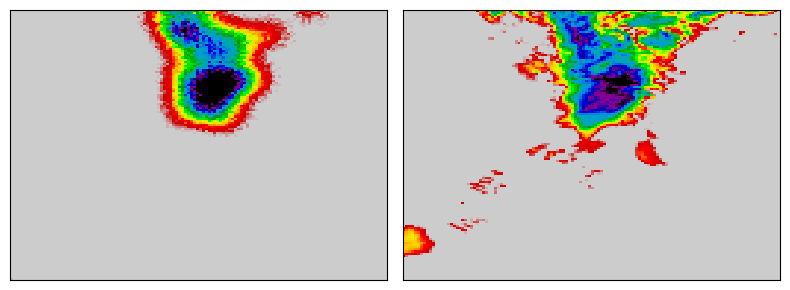

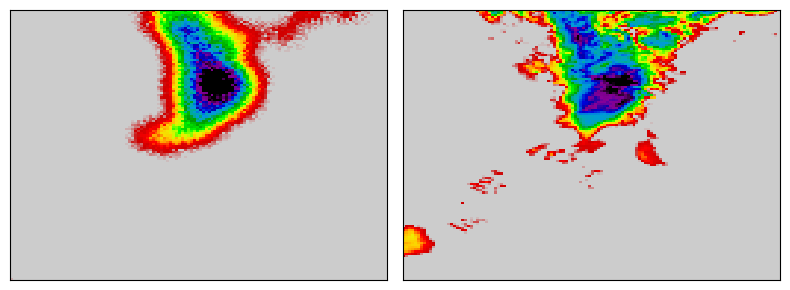

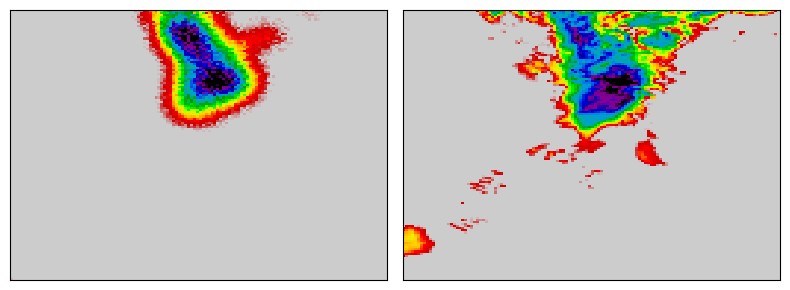

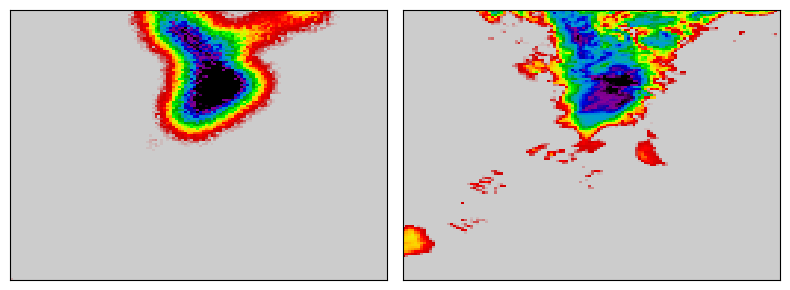

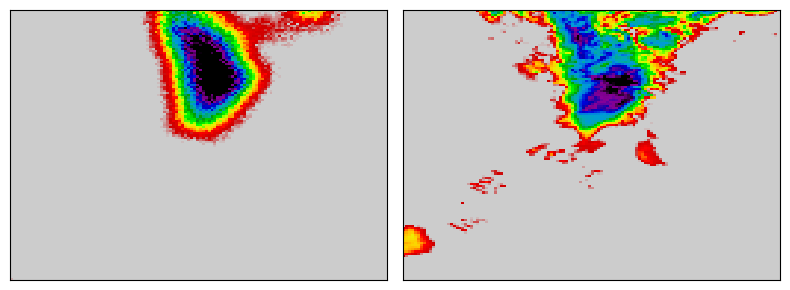

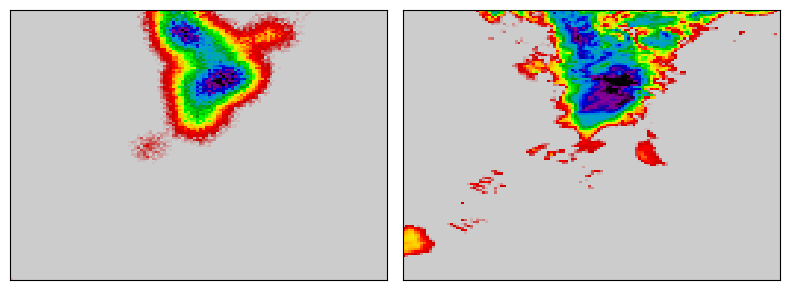

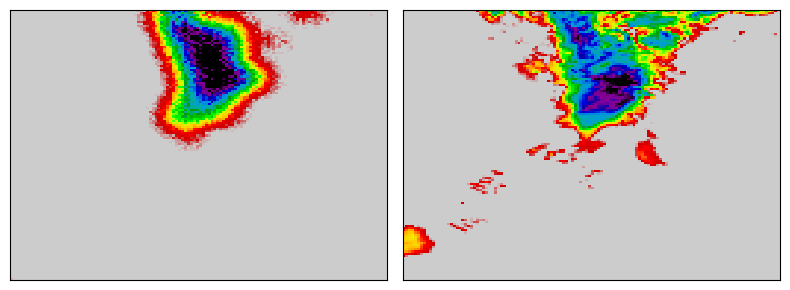

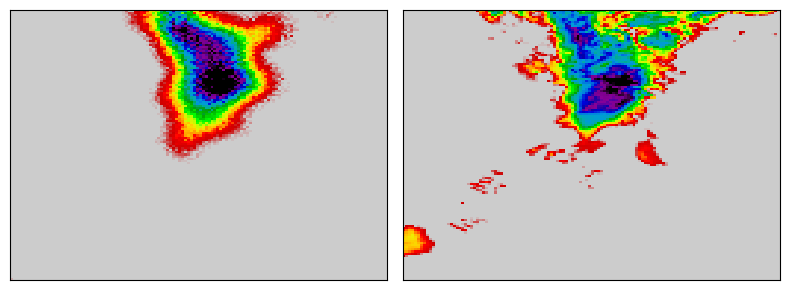

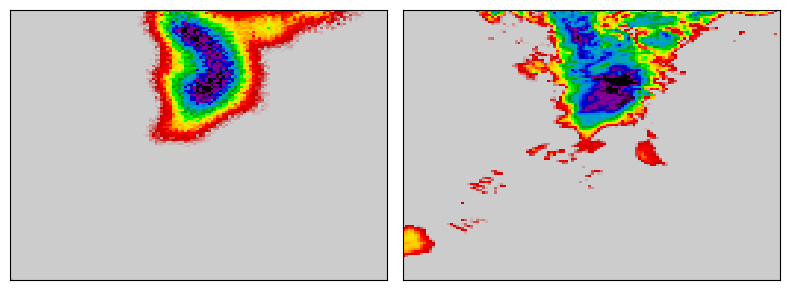

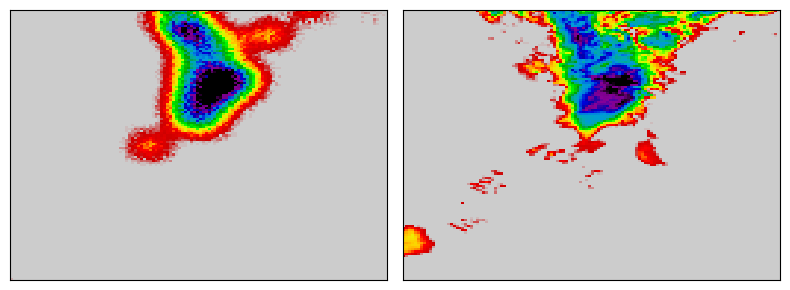

In [58]:
for i in range(10):

    fig, AX = plt.subplots(1, 2, figsize=(8, 3))
    
    for ax in AX:
        ax.tick_params(axis="both", which="both", bottom=False, 
                       top=False, labelbottom=False, left=False,
                       right=False, labelleft=False)
    plt.tight_layout()
    
    AX[0].pcolormesh(Y_pred[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)
    AX[1].pcolormesh(Y_valid[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)